In [2]:
import numpy as np
import pennylane as qml 
from pennylane import numpy as np
import matplotlib.pyplot as plt
import time
from qiskit_ibm_provider import IBMProvider
from qiskit.providers.fake_provider import *

In [303]:
class VQA: 

    def __init__(self, qubits, shots):
        self.qubits = qubits
        self.shots = shots

class VQSD(VQA):

    def __init__(self, qubits, shots):
        super().__init__(qubits, shots)
        #self.depth = depth

    def run(self, param = None):
        #if param == None:
        #    param = []
        #    d = 1
        #    L = self.qubits + 2*(self.qubits - 1)*d
        #    for i in range(L):
        #        param.append(i)
        #print(param)
        
        def test_prep(param):
            for i in range(2*self.qubits):
                qml.Hadamard(i)
        
        def cost_cirq(param):
            for i in range(self.qubits):
                qml.CNOT(wires = [i,i+self.qubits])


        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def initial_layer(param, q):
            for i in range(self.qubits):
                rot(param[i], i+q)

        def rot_ent(param, i, j):
            qml.CNOT(wires = [i, i+1])
            rot(param[j], i)
            rot(param[j+1], i+1)

        def rot_block(param, q):
            e = []
            o = []
            for i in range(self.qubits - 1):
                if i % 2 == 0:
                    e.append(i)
                    rot_ent(param, i + q, self.qubits + i)
                else:
                    o.append(i)
                
            for k in range(len(o)):
                rot_ent(param, o[k] + q, self.qubits + e[-1] + 2*(k+1))

        def Ansatz_block(param, q):
            initial_layer(param, q)
            rot_block(param, q)
            
        def Ansatz(param):
            Ansatz_block(param, 0)
            Ansatz_block(param, self.qubits)

        #def Ansatz(param):
        #    qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(self.qubits))
        #    qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(self.qubits, 2*self.qubits))

        dev = qml.device("default.qubit", wires = 2*self.qubits, shots = self.shots)
        @qml.qnode(dev, interface="autograd")
        def vqsd(param):
            test_prep(param)
            Ansatz(param)
            cost_cirq(param)
            return qml.probs(wires = [i for i in range(self.qubits, 2*self.qubits)])

        #drawer = qml.draw(vqsd)
        #print(drawer((param)))

        def output(param):
            return 1-vqsd(param)[0] 

        return (output(param))

    def eval_readout(self, param = None):
        #if param == None:
        #    param = []
        #    d = 1
        #    L = self.qubits + 2*(self.qubits - 1)*d
        #    for i in range(L):
        #        param.append(1.57)

        def opt_test_prep(param):
            for i in range(self.qubits):
                qml.Hadamard(i)
                
        def rot(theta, i):
            qml.RZ(theta, wires = i)
            qml.RX(np.pi/2, wires = i)

        def initial_layer(param, q):
            for i in range(self.qubits):
                rot(param[i], i+q)

        def rot_ent(param, i, j):
            qml.CNOT(wires = [i, i+1])
            rot(param[j], i)
            rot(param[j+1], i+1)

        def rot_block(param, q):
            e = []
            o = []
            for i in range(self.qubits - 1):
                if i % 2 == 0:
                    e.append(i)
                    rot_ent(param, i + q, self.qubits + i)
                else:
                    o.append(i)
                
            for k in range(len(o)):
                rot_ent(param, o[k] + q, self.qubits + e[-1] + 2*(k+1))

        def Ansatz_block(param, q):
            initial_layer(param, q)
            rot_block(param, q)
            
        def Ansatz(param):
            Ansatz_block(param, 0)
            Ansatz_block(param, self.qubits)

        #def Ansatz(param):
        #    qml.SimplifiedTwoDesign(initial_layer_weights=param[0], weights=param[1], wires=range(self.qubits))

        dev2 = qml.device("default.mixed", wires = self.qubits, shots = self.shots)
        @qml.qnode(dev2, interface = "autograd")
        def eval_read(param):
            opt_test_prep(param)
            Ansatz_block(param, 0)
            return qml.probs()
        
        #drawer = qml.draw(eval_read)
        #print(drawer((param)))

        return (eval_read(param))

    def opt(self, step, theta = None):
        if theta == None:
            theta = 0
            angle = []
            t = []
            d = 1
            L = self.qubits + 2*(self.qubits - 1)*d
            for i in range(L):
                t.append(0)
                t.append(2*(np.pi)*(np.random.uniform()))
            theta = np.array(t, requires_grad=True)
            angle = [theta]
            print(theta)
            #break
        else:
            angle = theta
        
        

        error = []
        diag = []
        Ev = []
        Ev0 = []
        Ev1 = []
        angle = []
        count = 0
        #shapes = qml.SimplifiedTwoDesign.shape(n_layers=depth, n_wires=self.qubits)
        #theta = [np.random.random(size=shape) for shape in shapes]
        #for i in range(2**self.qubits):
        #    Ev.append(self.eval_readout(theta)[i])

        #angle = [theta]
        diag = [self.run(theta)]
        Ev = [self.eval_readout(theta)]
        #Ev0 = [self.eval_readout(theta)[1]]
        #Ev1 = [self.eval_readout(theta)[0]]

        opt = qml.GradientDescentOptimizer(stepsize=step)
        max_iterations = 1000
        conv_tol = 1e-03
        start_time = time.time()

        for n in range(max_iterations):
            theta, prev_diag = opt.step_and_cost(self.run, theta)

            diag.append(self.run(theta))
            angle.append(theta)
            Ev = np.vstack((Ev, self.eval_readout(theta)))
            conv = 1 - max(Ev[-1,:])
            error.append(conv)

            #Ev0.append(self.eval_readout(theta)[1])
            #Ev1.append(self.eval_readout(theta)[0])

            #conv = np.abs(diag[-1])
            

            #if n % 40 ==0:
                

            if n % 10 == 0:
                print(f"Step = {n},  Diagonality = {diag[-1]:.8f}, Eigen_Values = {Ev[-1]}")
            
            if n == max_iterations:
                print("\n"f"Max iterations = {max_iterations}")
                break
    
            if round(conv.item(), 3) <= conv_tol:
                #count += 1
                max_iterations = n
                print("\n"f"Max iterations = {n}")
                print(f"The max eigenvalue is {max(Ev[-1,:])}")
                #print(f"1 - The max eigenvalue is {1- max(Ev[-1,:])}")
                print(f"The convergence is {conv}")
                print(f"The eigenvalue error is {round(conv.item(), 3)}")
                break

        print("\n" f"Optimization runtime = {time.time() - start_time}s")
        print("\n" f"Optimal value of the circuit parameter = {angle[-1]}")
        print("\n" f"Eigenvalues are: {Ev[-1,:]}")
        #print("\n" f"Eigenvalues are: {self.eval_readout(angle[-1])}")
        #opt_angle = angle[-1]

        fig = plt.figure()
        fig.set_figheight(5)
        fig.set_figwidth(12)
        
        

        plt.plot(range(len(diag)), diag, "k", ls = "solid")
        for i in range(len(Ev[n,:])):
            plt.plot(range(len(diag)), Ev[:,i], 'r', ls="dashed")
            #plt.plot(range(len(diag)), Ev[i,1], "r", ls="dashed")
            #plt.plot(range(len(diag)), Ev[i,2], "b", ls="dashed")
        #plt.plot(range(len(diag)), Ev0, "r", ls="dashed")
        #plt.plot(range(len(diag)), Ev1, "b", ls="dashed")
#plt.set_xlabel("Optimization step", fontsize=13)
#plt.set_ylabel("Diagonality", fontsize=13)

        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        plt.show()

        #return Ev

Step = 0,  Diagonality = 0.64000000, Eigen_Values = [0.06 0.04 0.04 0.04 0.4  0.41 0.01 0.  ]
Step = 10,  Diagonality = 0.59000000, Eigen_Values = [0.02 0.01 0.   0.   0.43 0.54 0.   0.  ]
Step = 20,  Diagonality = 0.51000000, Eigen_Values = [0.   0.   0.   0.   0.43 0.57 0.   0.  ]
Step = 30,  Diagonality = 0.17000000, Eigen_Values = [0.   0.   0.   0.   0.09 0.91 0.   0.  ]
Step = 40,  Diagonality = 0.01000000, Eigen_Values = [0. 0. 0. 0. 0. 1. 0. 0.]

Max iterations = 41

Optimization runtime = 4.712145566940308s

Optimal value of the circuit parameter = [ 4.00000000e-03  3.14656608e+00 -1.10000000e-02  1.58730314e+00
 -2.20000000e-02  4.69182387e+00 -1.49200000e+00  5.01877360e+00
  0.00000000e+00  1.82655431e-01  0.00000000e+00  1.16508429e+00
  0.00000000e+00  5.21779992e+00]

Eigenvalues are: [0. 0. 0. 0. 0. 1. 0. 0.]


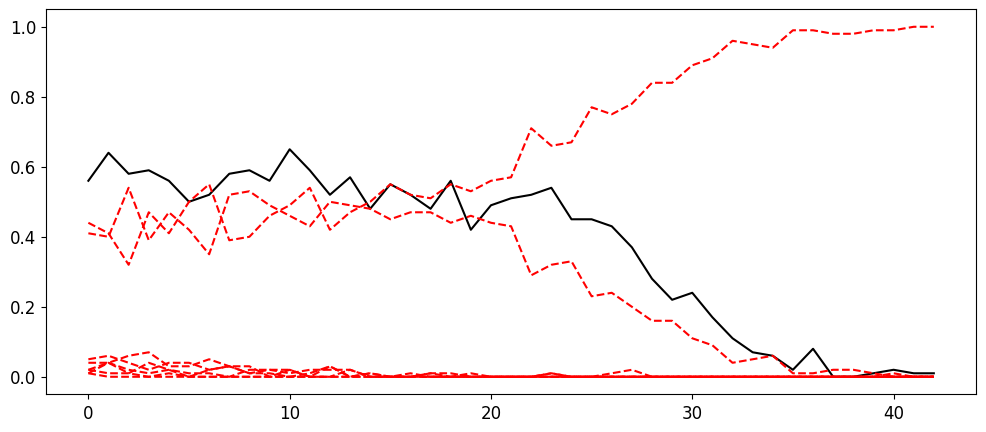

In [176]:
z = VQSD(3, 100)
z.opt(0.2)

Step = 0,  Diagonality = 0.91000000, Eigen_Values = [0.04 0.01 0.06 0.13 0.   0.08 0.15 0.02 0.02 0.01 0.09 0.09 0.02 0.16
 0.07 0.05]
Step = 10,  Diagonality = 0.90000000, Eigen_Values = [0.03 0.02 0.1  0.07 0.   0.06 0.21 0.01 0.04 0.01 0.1  0.08 0.01 0.08
 0.14 0.04]
Step = 20,  Diagonality = 0.85000000, Eigen_Values = [0.01 0.02 0.22 0.01 0.   0.05 0.3  0.   0.   0.05 0.2  0.03 0.   0.
 0.11 0.  ]
Step = 30,  Diagonality = 0.10000000, Eigen_Values = [0.01 0.   0.05 0.   0.01 0.   0.92 0.   0.   0.   0.   0.   0.   0.
 0.01 0.  ]

Max iterations = 34

Optimization runtime = 8.151389360427856s

Optimal value of the circuit parameter = [ 2.40000000e-02 -5.53638252e-03 -1.80000000e-02  6.26942842e+00
  1.56600000e+00  3.11738990e+00 -2.70000000e-02  1.53713945e+00
  1.54800000e+00  4.65650909e+00  0.00000000e+00  1.12198263e+00
  0.00000000e+00  3.58238501e+00  0.00000000e+00  5.00475460e+00
  0.00000000e+00  1.59345277e+00  0.00000000e+00  2.02110325e+00]

Eigenvalues are: [0. 0. 0. 0

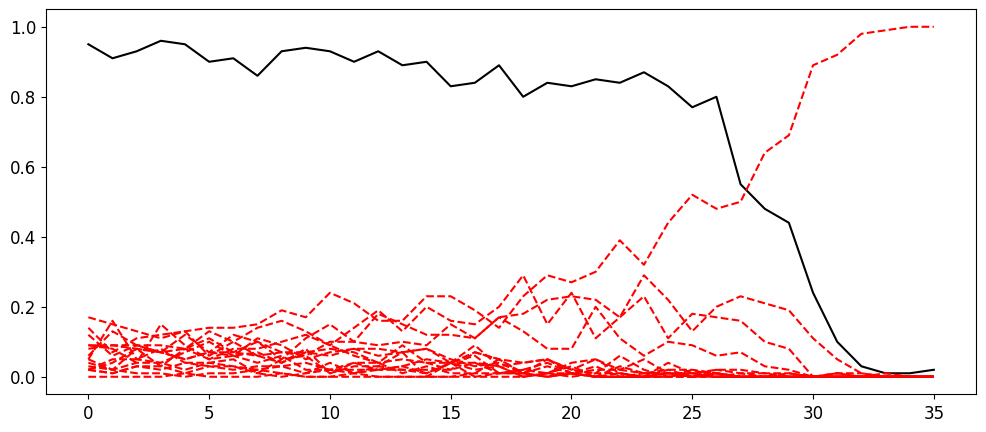

In [178]:
z = VQSD(4, 100)
z.opt(0.6)

Step = 0,  Diagonality = 0.91000000, Eigen_Values = [0.   0.02 0.   0.02 0.   0.   0.02 0.01 0.01 0.03 0.   0.   0.   0.
 0.   0.02 0.15 0.1  0.02 0.01 0.16 0.14 0.   0.01 0.   0.01 0.04 0.06
 0.01 0.02 0.05 0.09]
Step = 10,  Diagonality = 0.76000000, Eigen_Values = [0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.03 0.
 0.   0.   0.19 0.27 0.   0.   0.21 0.19 0.   0.   0.   0.01 0.01 0.02
 0.   0.01 0.02 0.02]
Step = 20,  Diagonality = 0.08000000, Eigen_Values = [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.98 0.   0.   0.   0.01 0.   0.
 0.   0.   0.   0.  ]

Max iterations = 22

Optimization runtime = 8.927066087722778s

Optimal value of the circuit parameter = [-7.80000000e-02  3.21790494e+00  4.80000000e-02  8.74136258e-02
 -5.03069808e-17  1.55808933e+00 -6.00000000e-03  3.13599924e+00
 -3.30000000e-02  1.59366360e+00  1.51800000e+00  1.57752810e+00
 -1.53300000e+00  2.59169877e-01  0.00000000e+00  9.08816

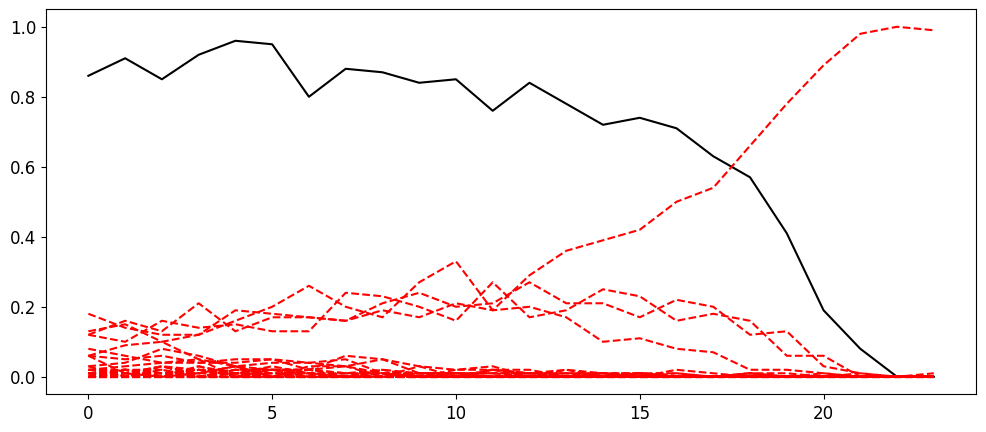

In [179]:
a = VQSD(5,100)
a.opt(0.6)

In [184]:
b = VQSD(6,100)
b.opt(0.8)

Step = 0,  Diagonality = 0.97000000, Eigen_Values = [0.09 0.05 0.01 0.02 0.08 0.03 0.02 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.09 0.03 0.   0.   0.05 0.03 0.02 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.1  0.02 0.01 0.03 0.06 0.07 0.02 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.08 0.   0.   0.01 0.03 0.04 0.01 0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Step = 10,  Diagonality = 0.88000000, Eigen_Values = [0.09 0.   0.   0.   0.07 0.01 0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.14 0.01 0.   0.   0.13 0.03 0.01 0.   0.   0.   0.   0.
 0.01 0.   0.   0.   0.07 0.02 0.   0.   0.12 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.1  0.   0.   0.01 0.15 0.03 0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.  ]
Step = 20,  Diagonality = 0.82000000, Eigen_Values = [0.11 0.   0.   0.   0.1  0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.14 0.01 0.   0.   0.22 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.

KeyboardInterrupt: 

[0.         0.63080602 0.         1.83698582 0.         2.2398645
 0.         6.01457662 0.         5.38206563 0.         0.24112944
 0.         6.15630191 0.         2.03245712 0.         1.7087809
 0.         2.54717756 0.         1.89530904 0.         4.90498207
 0.         0.01776004 0.         2.01292138 0.         5.0569073
 0.         0.48357064 0.         1.05527199 0.         4.46749155
 0.         3.30930182]
Step = 0,  Diagonality = 0.98000000, Eigen_Values = [0.   0.   0.   0.02 0.   0.01 0.   0.   0.   0.   0.   0.01 0.   0.
 0.   0.03 0.   0.   0.01 0.02 0.   0.   0.05 0.02 0.02 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.01 0.03 0.   0.   0.01 0.   0.01 0.
 0.01 0.02 0.   0.01 0.01 0.01 0.   0.   0.   0.01 0.01 0.01 0.02 0.01
 0.01 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.02 0.   0.01
 0.02 0.01 0.   0.   0.02 0.03 0.   0.   0.   0.03 0.01 0.   0.01 0.03
 0.   0.   0.03 0.01 0.   0.   0.   0.01 0.   0.   0.01 0.01 0.   0.
 0.05 0.04 0.   0.   0.06 0.04 0.   

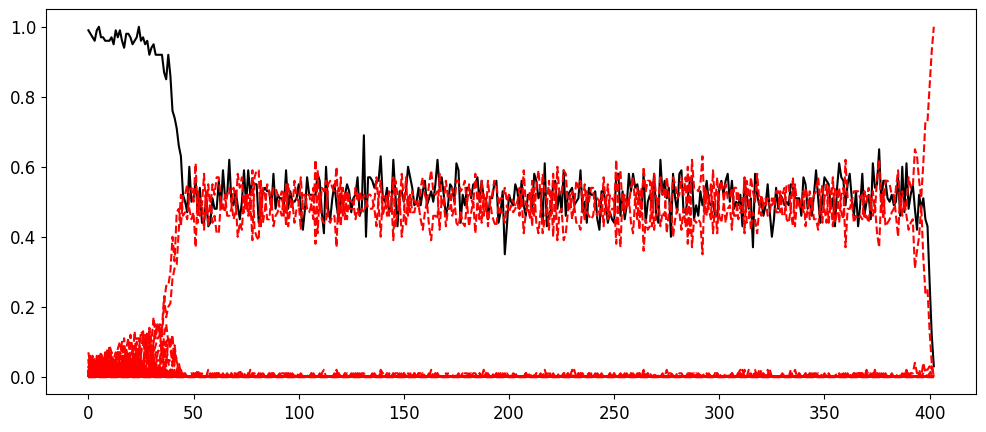

In [302]:
b = VQSD(7,100)
b.opt(1.0)

Step = 0,  Diagonality = 0.97000000, Eigen_Values = [0.   0.   0.   0.   0.01 0.   0.   0.   0.02 0.01 0.04 0.01 0.   0.
 0.01 0.   0.02 0.   0.   0.   0.   0.   0.   0.   0.05 0.03 0.01 0.
 0.   0.01 0.03 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.01 0.
 0.   0.   0.05 0.   0.   0.01 0.02 0.02 0.01 0.   0.01 0.   0.   0.01
 0.   0.   0.01 0.   0.02 0.   0.   0.   0.03 0.   0.01 0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.
 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.02 0.   0.01 0.
 0.02 0.01 0.02 0.   0.01 0.   0.   0.   0.   0.   0.01 0.   0.02 0.02
 0.02 0.   0.03 0.02 0.01 0.   0.01 0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0

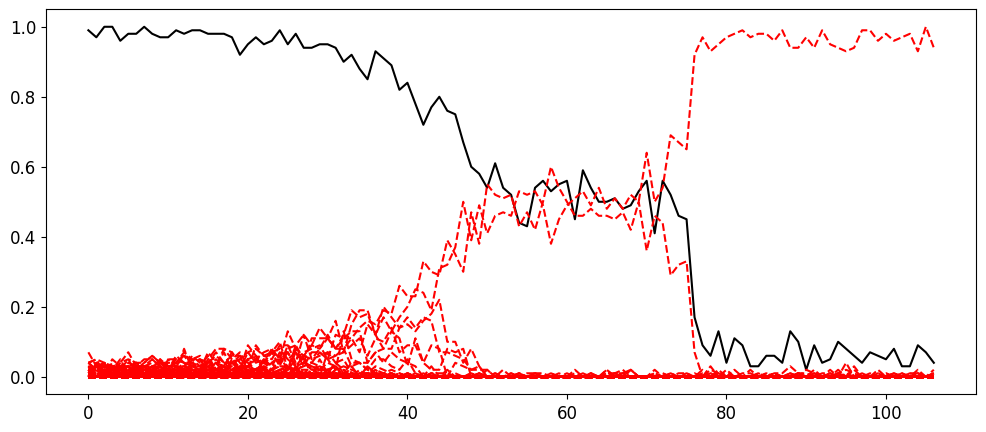

In [92]:
b = VQSD(8,100)
b.opt(1.5)

In [93]:
b = VQSD(9,100)
b.opt(1.7)

Step = 0,  Diagonality = 0.99000000, Eigen_Values = [0.01 0.   0.   0.   0.   0.   0.   0.01 0.   0.   0.   0.   0.   0.
 0.01 0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.
 0.   0.   0.01 0.02 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.01 0.   0.01 0.01 0.   0.   0.   0.01 0.
 0.   0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.01 0.   0.
 0.   0.01 0.   0.02 0.   0.   0.   0.02 0.01 0.   0.   0.   0.   0.
 0.   0.   0.   0.   0.01 0.01 0.   0.   0.   0.02 0.   0.   0.   0.
 0.   0.   0.   0.02 0.   0.   0.   0.   0.02 0.   0.02 0.01 0.   0.
 0.   0.   0.01 0.01 0.   0.   0.   0.01 0.   0.   0.01 0.   0.   0.
 0.   0.01 0.   0.01 0.01 0.02 0.   0.   0.01 0.01 0.03 0.   0.   0.01
 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.   0.01 0.   0.
 0.   0.   0.01 0.   0.01 0.01 0.01 0.   0.   0.0

KeyboardInterrupt: 